In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [2]:
# Loads the data into a dataframe
df = pd.read_csv("/Users/lin/Desktop/Jan_2019_ontime.csv")
df2 = pd.read_csv("/Users/lin/Desktop/Jan_2020_ontime.csv")
df.append(df2)
df.shape

(583985, 22)

In [3]:
# Creates a standard baseline binary classifier accuracy by using all of our avaliable data
df.ARR_DEL15.value_counts()

0.0    460741
1.0    105222
Name: ARR_DEL15, dtype: int64

In [4]:
base_accuracy = 460741 / (460741 + 105222)
base_error = 1 - base_accuracy
print('Baseline Accuracy: ', base_accuracy)
print('Baseline Error: ', base_error)

Baseline Accuracy:  0.8140832527921437
Baseline Error:  0.18591674720785634


In [5]:
# Chooses a random sample of 5% of the data to learn on
df = df.sample(frac=0.001)
df = df.drop(['Unnamed: 21', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'OP_CARRIER_AIRLINE_ID',
             'DEP_TIME_BLK', 'DEP_DEL15', 'ARR_TIME', 'CANCELLED', 'DIVERTED'], axis=1)
df = df.dropna()
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_DEL15,DISTANCE
571160,31,4,DL,N358NB,1156,PDX,SEA,729.0,0.0,129.0
570502,31,4,B6,N317JB,2279,BOS,EWR,729.0,1.0,200.0
416917,23,3,OO,N170SY,3302,SAN,FAT,1234.0,0.0,314.0
273474,15,2,AA,N575UW,609,BWI,CLT,842.0,0.0,361.0
62213,4,5,UA,N677UA,638,IAH,ORD,746.0,1.0,925.0


In [44]:
# Splits data into test and training sets
X = df.drop('ARR_DEL15', axis=1)
y = df.ARR_DEL15
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype('category')
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DISTANCE
559051,30,3,AA,N903AA,1229,DFW,SAN,1208.0,1171.0
41999,3,4,F9,N721FR,2015,CLE,LAS,2008.0,1824.0
46875,3,4,WN,N966WN,2232,MDW,DAL,632.0,793.0
192511,11,5,WN,N795SW,1599,ATL,MDW,1210.0,591.0
222534,12,6,WN,N775SW,2444,MSY,BNA,835.0,471.0


In [45]:
# One-hot-encodes categorical features and standardizes numerical features
X_num = X[['DEP_TIME', 'DISTANCE']]
X_num = (X_num - X_num.mean())/X_num.std()
X_cat = X.drop(['DEP_TIME', 'DISTANCE'], axis=1)
X_cat = pd.get_dummies(X_cat)
X = X_num.join(X_cat)
X.head()

,DEP_TIME,DISTANCE,DAY_OF_MONTH,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,...,DEST_SNA,DEST_SRQ,DEST_STL,DEST_SYR,DEST_TLH,DEST_TPA,DEST_TTN,DEST_TUS,DEST_UIN,DEST_VEL
559051,-0.262806,0.654267,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,1.357343,1.792268,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46875,-1.429314,-0.004483,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192511,-0.258756,-0.356514,11,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
222534,-1.018201,-0.565641,12,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
B = np.arange(10,200,10)
grid = {'n_estimators':B}

rf = RandomForestClassifier()
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
             return_train_score=True)

In [73]:
rf = RandomForestClassifier(n_estimators=150,oob_score=True)
rf.fit(X,y)

RandomForestClassifier(n_estimators=150, oob_score=True)

In [74]:
print('out-of-bag R2',rf.oob_score_.round(3))

out-of-bag R2 0.792


In [75]:
cv_results = cross_validate(rf,X,y,return_train_score=True)
R2_trainCV = cv_results['train_score'].mean()
R2_validCV = cv_results['test_score'].mean()
print('train R2(CV)', R2_trainCV.round(3))
print('valid R2(CV)', R2_validCV.round(3))

train R2(CV) 1.0
valid R2(CV) 0.793


<AxesSubplot:xlabel='trees'>

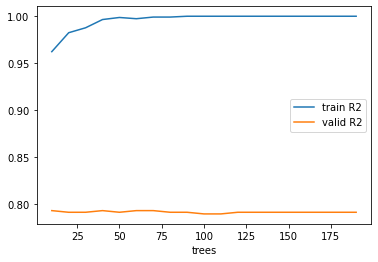

In [76]:
results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2'] = rfCV.cv_results_['mean_test_score']

ax1 = results.plot.line(x='trees',y='train R2')
results.plot.line(x='trees', y='valid R2',ax=ax1)

## Gradient Boosting Tree

In [6]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [7]:
# Loads the data into a dataframe
df = pd.read_csv("/Users/lin/Desktop/Jan_2019_ontime.csv")
df2 = pd.read_csv("/Users/lin/Desktop/Jan_2020_ontime.csv")
df.append(df2)
df.shape

(583985, 22)

In [8]:
# Chooses a random sample of 5% of the data to learn on
df = df.sample(frac=0.001)
df = df.drop(['Unnamed: 21', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'OP_CARRIER_AIRLINE_ID',
             'DEP_TIME_BLK', 'DEP_DEL15', 'ARR_TIME', 'CANCELLED', 'DIVERTED'], axis=1)
df = df.dropna()
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_DEL15,DISTANCE
456499,25,5,WN,N960WN,3338,OAK,MCI,1053.0,0.0,1489.0
343930,19,6,AA,N567UW,1920,ORD,PHX,1434.0,1.0,1440.0
405525,22,2,DL,N951AT,2516,LAS,LAX,1300.0,0.0,236.0
466313,25,5,DL,N882DN,851,PBI,ATL,1631.0,0.0,545.0
392861,21,1,WN,N7702A,2012,SMF,ONT,2049.0,0.0,390.0


In [9]:
# Splits data into test and training sets
X = df.drop('ARR_DEL15', axis=1)
y = df.ARR_DEL15
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype('category')
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DISTANCE
456499,25,5,WN,N960WN,3338,OAK,MCI,1053.0,1489.0
343930,19,6,AA,N567UW,1920,ORD,PHX,1434.0,1440.0
405525,22,2,DL,N951AT,2516,LAS,LAX,1300.0,236.0
466313,25,5,DL,N882DN,851,PBI,ATL,1631.0,545.0
392861,21,1,WN,N7702A,2012,SMF,ONT,2049.0,390.0


In [10]:
X_num = X[['DEP_TIME', 'DISTANCE']]
# X_num = (X_num - X_num.mean())/X_num.std()
X_cat = X.drop(['DEP_TIME', 'DISTANCE'], axis=1)
X_cat = pd.get_dummies(X_cat)
X = X_num.join(X_cat)
X.head()

,DEP_TIME,DISTANCE,DAY_OF_MONTH,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,...,DEST_SLC,DEST_SMF,DEST_SNA,DEST_STL,DEST_STT,DEST_SYR,DEST_TPA,DEST_TUL,DEST_TUS,DEST_XNA
456499,1053.0,1489.0,25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
343930,1434.0,1440.0,19,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
405525,1300.0,236.0,22,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466313,1631.0,545.0,25,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
392861,2049.0,390.0,21,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
(X_train, X_test) = train_test_split(X,train_size=0.8,test_size=0.2,random_state=0)

In [12]:
y = y.astype('category')

In [13]:
(y_train, y_test) = train_test_split(y,train_size=0.8,test_size=0.2,random_state=0)

In [14]:
92/114

0.8070175438596491

In [15]:
depth = 2
gbt = GradientBoostingClassifier(max_depth=depth,n_estimators=10000,learning_rate=0.01)

In [25]:
gbt.fit(X_train,y_train)
results = pd.DataFrame()
accuracy = []
results['accuracy'] = []
for yh in gbt.staged_predict(X_train):
    train = (y_train == yh).value_counts()
    print(train)
#     accuracy.append(train[1]/(train[0]+train[1]))
#     results['accuracy'].append(accuracy)
#     print("train: ", )


True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype: int64
True     377
False     75
Name: ARR_DEL15, dtype

In [26]:
n_trees=100000
gbt = GradientBoostingClassifier(max_depth=3,n_estimators=n_trees,learning_rate=0.1)
gbt.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=100000)

In [27]:
yh_test = gbt.predict(X_test)

In [28]:
y_test.shape

(114,)

In [40]:
(y_test == yh_test).value_counts()

True     98
False    16
Name: ARR_DEL15, dtype: int64

In [41]:
98/114

0.8596491228070176

In [133]:
tree=[]
R2_train=[]
R2_test=[]
yh_train= iter(gbt.staged_predict(X_train))
yh_test = iter(gbt.staged_predict(X_test))
for k in range(n_trees):
    tree.append(k+1)
    train = (y_train == next(yh_train)).value_counts()
    test = (y_test == next(yh_test)).value_counts()
    print("train: ", train[1]/(train[0]+train[1]))
    print("test: ", test[1]/(test[0]+test[1]))
    
#     R2_train.append(train[1]/(train[0]+train[1]))
#     R2_test.append(test[1]/(test[0]+test[1]))
    
# results = pd.DataFrame()
# results['trees'] = tree
# results['train R2'] = R2_train
# results['test R2'] = R2_test
# ax1 = results.plot.line(x='trees',y='train R2')
# results.plot.line(x='trees',y='test R2',ax=ax1)

train:  0.8207964601769911
test:  0.8070175438596491
train:  0.8207964601769911
test:  0.8070175438596491
train:  0.8207964601769911
test:  0.8070175438596491
train:  0.8207964601769911
test:  0.8070175438596491
train:  0.8407079646017699
test:  0.7894736842105263
train:  0.8407079646017699
test:  0.7894736842105263
train:  0.8407079646017699
test:  0.7894736842105263
train:  0.8429203539823009
test:  0.7894736842105263
train:  0.8429203539823009
test:  0.7894736842105263
train:  0.8429203539823009
test:  0.7894736842105263
train:  0.8407079646017699
test:  0.7894736842105263
train:  0.8407079646017699
test:  0.7894736842105263
train:  0.8407079646017699
test:  0.7894736842105263
train:  0.8407079646017699
test:  0.7894736842105263
train:  0.8407079646017699
test:  0.7894736842105263
train:  0.8473451327433629
test:  0.7894736842105263
train:  0.8495575221238938
test:  0.7894736842105263
train:  0.8473451327433629
test:  0.7894736842105263
train:  0.8473451327433629
test:  0.7894736842

KeyError: 0